# Notebook for visualizing the results of a stylegan3 training


In [4]:
import os

dataset_name = f"mestas"

results_dir = f"training-runs/{dataset_name.upper()}_TRAIN"
experiment_name = f"00000-stylegan3-t-{dataset_name}_train-gpus2-batch64-gamma0.125"

file_name = "stats.jsonl"
training_options_file_name = "training_options.json"
dataset_summary_file_name = f"data/{dataset_name}/patches/processing_summary.json"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

import json

with open(dataset_summary_file_name, "r") as f:
    summary = json.load(f)

label_map = summary.get("label_map", {})
print("Label Map:", label_map)

# Labels for the classes
class_labels = list(label_map.values())
print("Class Labels:", class_labels)


Error: The file training-runs/MESTAS_TRAIN/00000-stylegan3-t-mestas_train-gpus2-batch64-gamma0.125/stats.jsonl does not exist.
Label Map: {'2': 1, '7': 2, '8': 3, '10': 4}
Class Labels: [1, 2, 3, 4]


In [66]:
from visualization_utils import read_jsonl, extract_metrics, extract_classification_metrics, format_time, summarize_training_stats, \
    summarize_training_options, extract_confusion_matrix, plot_confusion_matrix, plot_metric, print_accuracies_per_class, \
    compute_avg_accuracy, compute_overall_accuracy, plot_accuracies, extract_best_tick, class_colors

In [67]:
summarize_training_options(os.path.join(results_dir, experiment_name, training_options_file_name))

False
📋 Training Configuration Summary
────────────────────────────────────
⚖️  Class weight: 0.1
🖥️  Number of GPUs: 2
📦 Batch size: 64
🎯 Uniform class labels: True
🧪 Discriminator on generated images: True
🎛️  ADA target present ✅ → Value: 0.6


In [68]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 4h 4min 46s
📊 Total kimg: 1620.032
📈 Total ticks: 162
⏱️ Mean time per tick: 1min 23s (std: 5s)
⏳ Mean time per kimg: 8s (std: 0s)


In [69]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 140
🖼️  kimg: 1406.784
📈 Avg Accuracy (Train): 0.9294 ± 0.0455
📊 Avg Accuracy (Val):   0.9267 ± 0.0505
🏁 Overall Accuracy (Train): 0.9461
✅ Overall Accuracy (Val):   0.9320


In [70]:


print("\n────────────────────────────────────")
print("Using overall accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data,
    class_labels,
    performance_key="overall",
    verbose=True,
    only_tick_with_pkl=False,
    network_snapshot_ticks=None,
)


────────────────────────────────────
Using overall accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 80
🖼️  kimg: 803.904
📈 Avg Accuracy (Train): 0.9183 ± 0.0458
📊 Avg Accuracy (Val):   0.9212 ± 0.0597
🏁 Overall Accuracy (Train): 0.9369
✅ Overall Accuracy (Val):   0.9393


In [71]:
print("\n────────────────────────────────────")
print("Considering only saved ticks with pkl files")
print("────────────────────────────────────\n")
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=True, network_snapshot_ticks=1
)

print("\n────────────────────────────────────")
print("Using overall accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="overall", verbose=True, only_tick_with_pkl=True, network_snapshot_ticks=1
)


────────────────────────────────────
Considering only saved ticks with pkl files
────────────────────────────────────

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 140
🖼️  kimg: 1406.784
📈 Avg Accuracy (Train): 0.9294 ± 0.0455
📊 Avg Accuracy (Val):   0.9267 ± 0.0505
🏁 Overall Accuracy (Train): 0.9461
✅ Overall Accuracy (Val):   0.9320

────────────────────────────────────
Using overall accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 80
🖼️  kimg: 803.904
📈 Avg Accuracy (Train): 0.9183 ± 0.0458
📊 Avg Accuracy (Val):   0.9212 ± 0.0597
🏁 Overall Accuracy (Train): 0.9369
✅ Overall Accuracy (Val):   0.9393


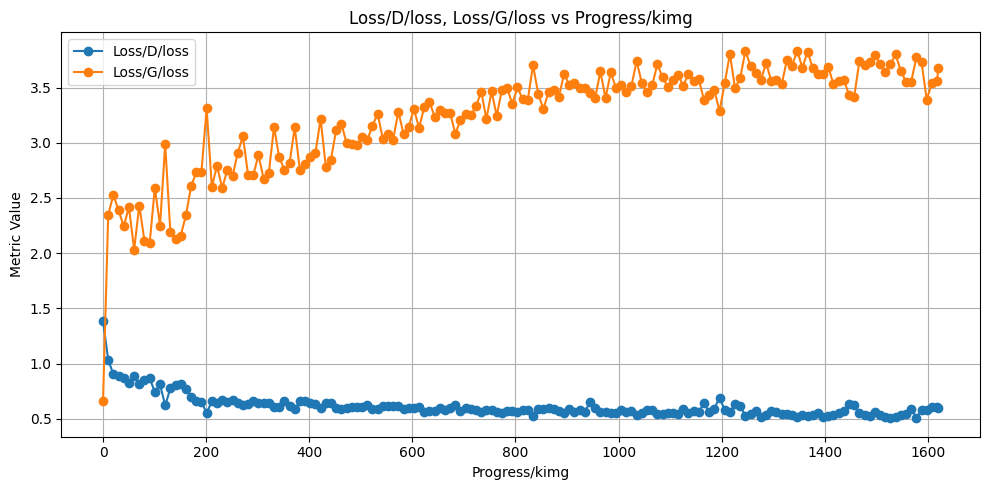

In [72]:
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

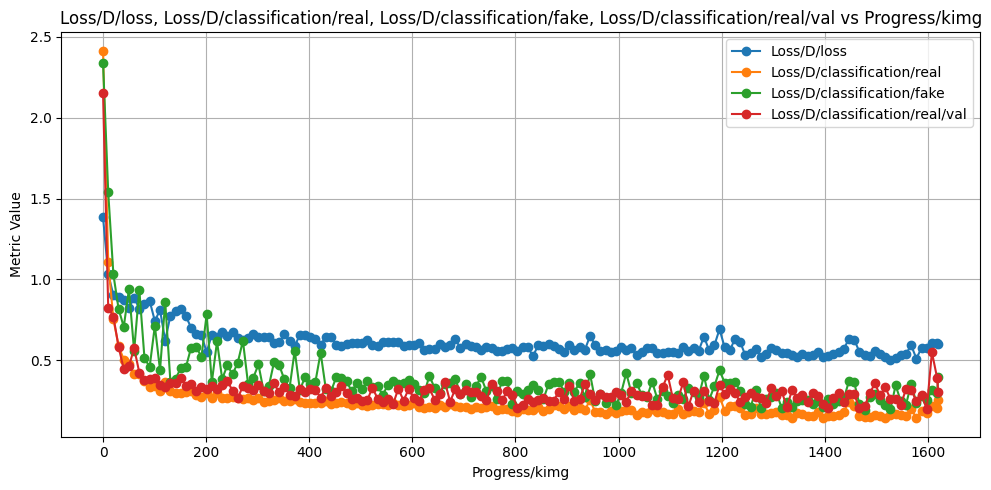

In [73]:
plot_metric(
    data=metrics,
    metrics=[
        "Loss/D/loss",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
)

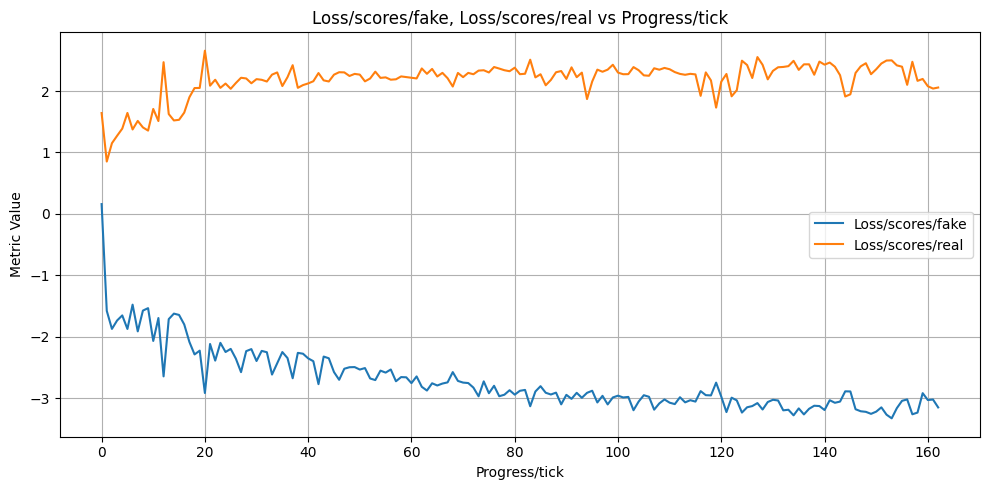

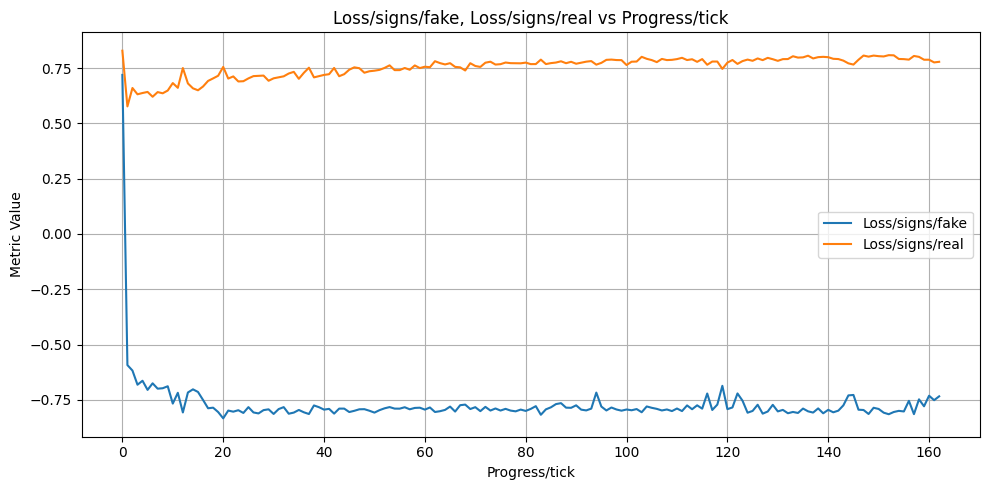

In [74]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

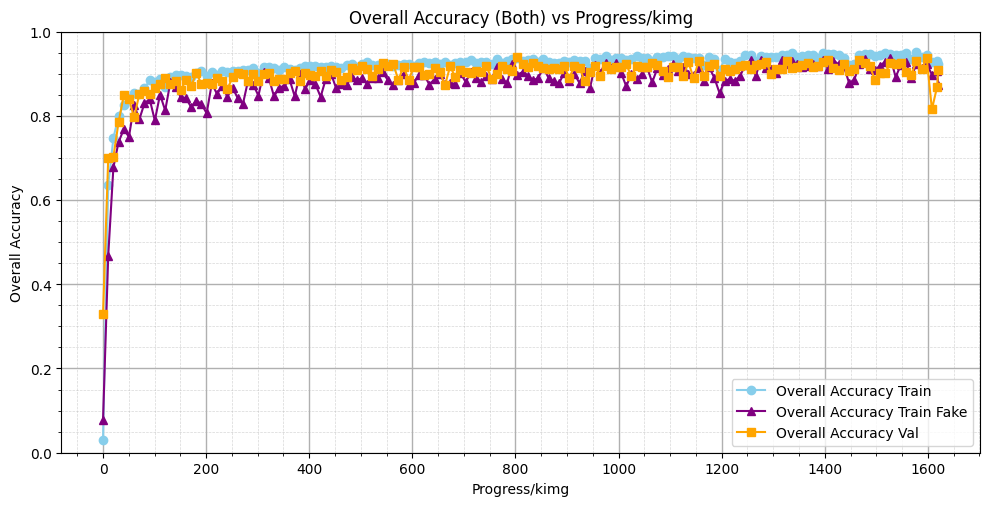

In [75]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
    compute_overall_accuracy(classification_metrics)
)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
    dataset="both",
    include_fake=True,
)

Last 10 accuracies per class (val):
Class 0: ['0.826', '0.804', '0.370', '0.739', '0.804', '0.826', '0.804', '0.783', '0.630', '0.826']
Class 1: ['0.840', '0.880', '0.880', '0.760', '0.760', '0.720', '0.960', '0.840', '0.640', '0.720']
Class 2: ['0.667', '0.556', '0.778', '0.889', '0.833', '0.778', '0.556', '0.889', '0.611', '0.833']
Class 3: ['1.000', '1.000', '1.000', '0.857', '0.857', '1.000', '1.000', '1.000', '1.000', '1.000']
Class 4: ['0.750', '0.958', '0.792', '0.750', '0.833', '0.500', '0.958', '0.875', '0.958', '0.875']
Class 5: ['0.800', '0.867', '0.933', '0.933', '0.867', '0.800', '0.867', '0.533', '1.000', '0.867']
Class 6: ['0.936', '0.916', '0.884', '0.936', '0.930', '0.904', '0.936', '0.626', '0.771', '0.948']
Class 7: ['0.934', '0.966', '0.963', '0.852', '0.963', '0.955', '0.958', '0.916', '0.953', '0.892']
Class 8: ['0.979', '0.979', '0.979', '1.000', '1.000', '0.979', '1.000', '1.000', '0.979', '0.979']
Class 9: ['0.950', '0.912', '0.961', '0.961', '0.928', '0.934', 

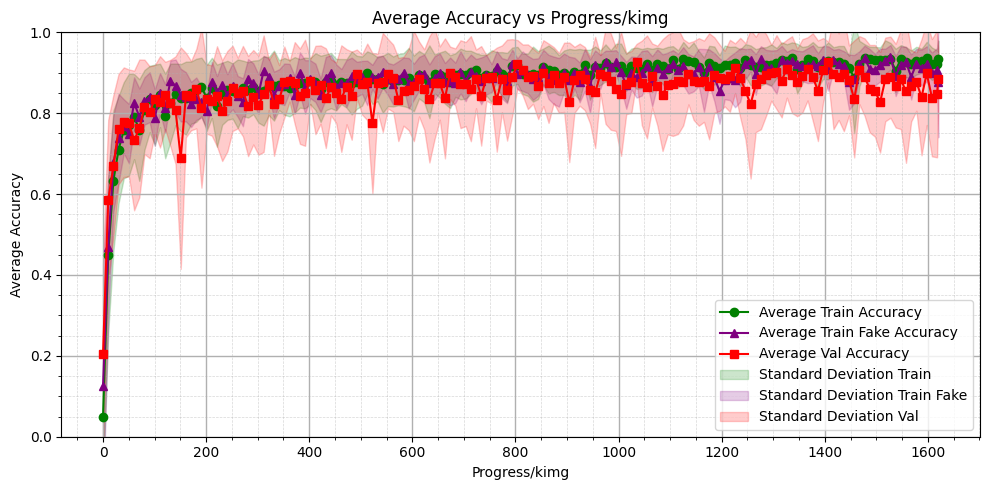

In [76]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, data_type="val")
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    dataset="both",
    include_fake=True,
)

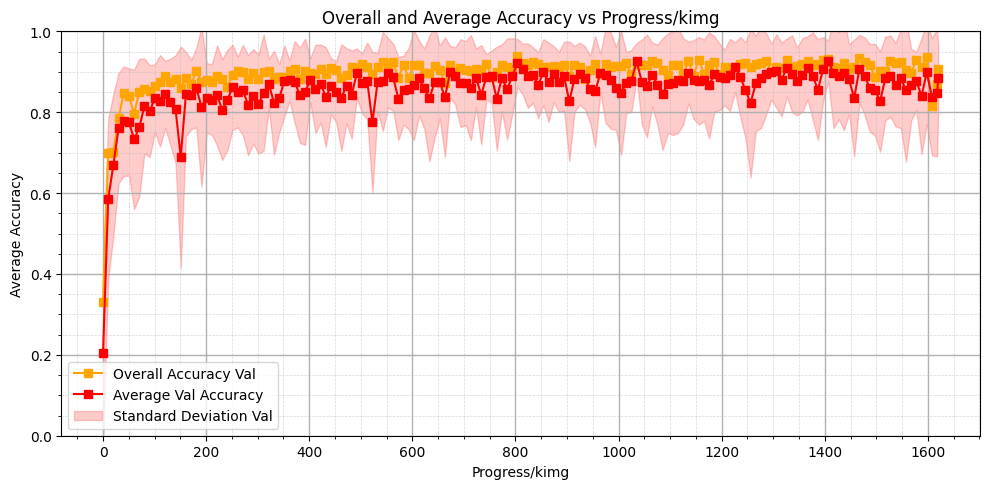

In [77]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    dataset="val",
)

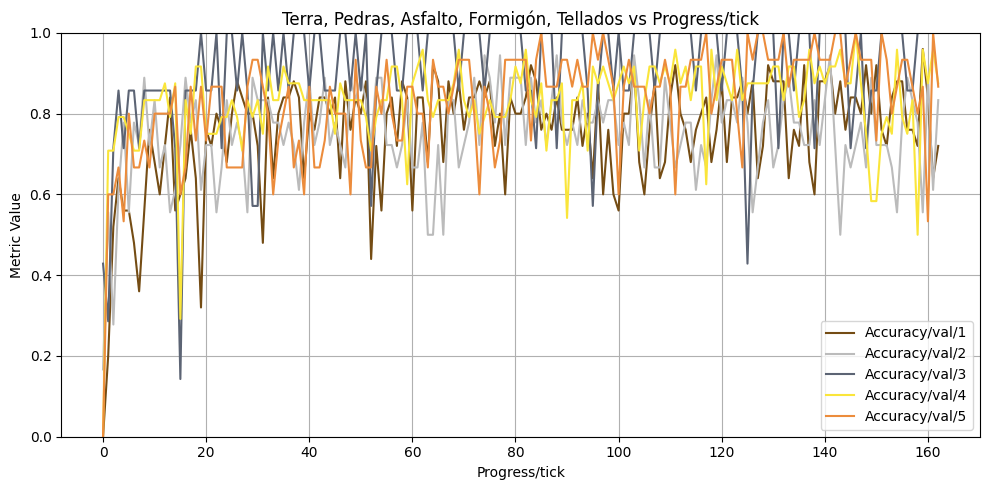

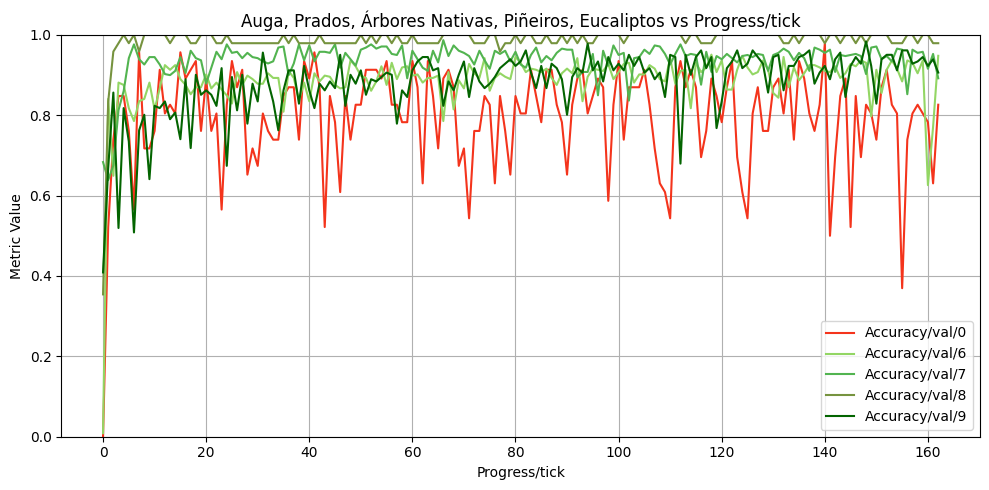

In [78]:
if "oitaven" in experiment_name:
    minority_class_labels = [1, 2, 3, 4, 5]
    colors = [class_colors[c] for c in minority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in minority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Terra, Pedras, Asfalto, Formigón, Tellados vs Progress/tick",
    )
    mayority_class_labels = [0, 6, 7, 8, 9]
    colors = [class_colors[c] for c in mayority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in mayority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Auga, Prados, Árbores Nativas, Piñeiros, Eucaliptos vs Progress/tick",
    )
else:
    first_class_labels = [0, 1, 2, 3, 4]
    colors = [class_colors[c] for c in first_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in first_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="0, 1, 2, 3, 4 vs Progress/tick",
    )
    last_class_labels = [5, 6, 7, 8, 9]
    colors = [class_colors[c] for c in last_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in last_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="5, 6, 7, 8, 9 vs Progress/tick",
    )

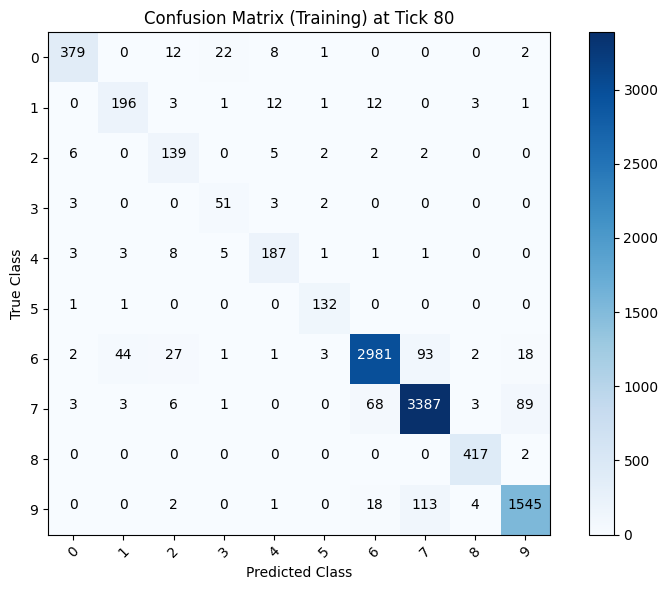

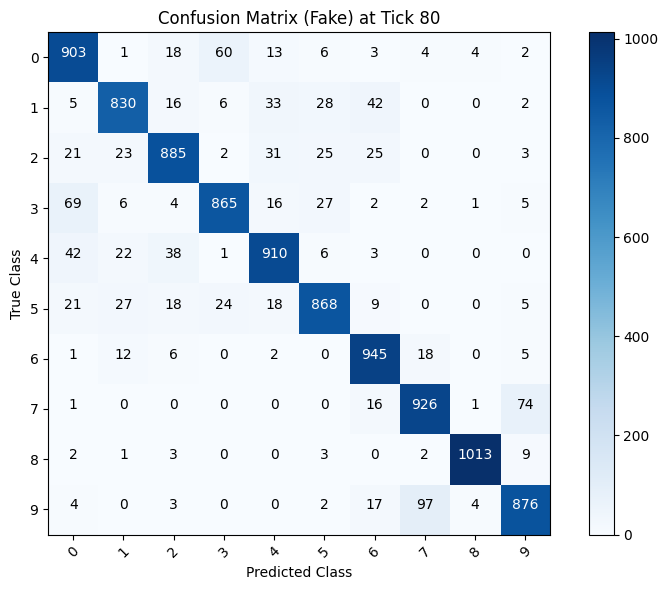

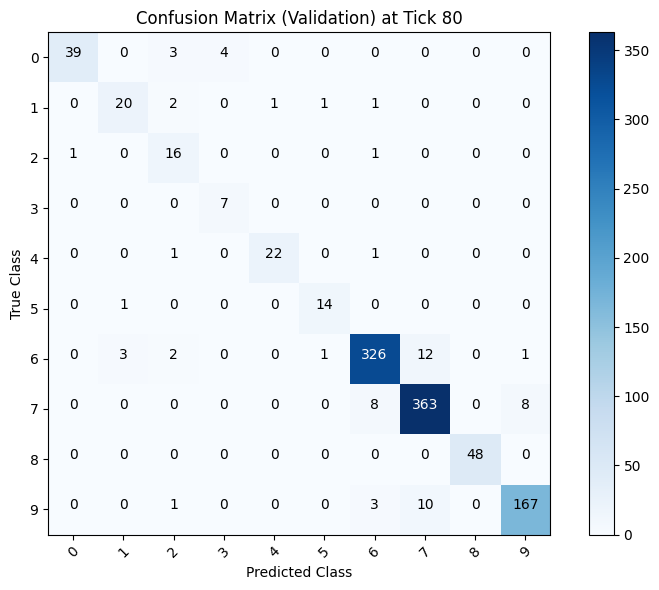

In [79]:
best_tick = int(best_tick_performance["tick"])
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="real"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Training) at Tick {best_tick}"
)
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="fake"
)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Fake) at Tick {best_tick}")
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="val"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Validation) at Tick {best_tick}"
)